#📌**Import Libraries**

In [40]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

##**Load Dataset & EDA (Exploratory Data Analysis)**

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
dataset_path = "/content/drive/MyDrive/hair_dataset"

In [43]:
import os
print(os.listdir(dataset_path))

['Straight', 'Wavy', 'kinky', 'curly', 'dreadlocks']


# **Experiment 1**

##**Data Preprocessing**

In [44]:
import pandas as pd

# Load dataset structure
data = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for img in os.listdir(class_dir):
            data.append({"filename": os.path.join(class_name, img), "Class": class_name})

df = pd.DataFrame(data)

# Print dataset structure
print(df.head())  # Display first few rows
print(f"Total images: {len(df)}")

                                            filename     Class
0  Straight/01-10-2019-latest-haircut-for-girls_s...  Straight
1            Straight/1-short-spiky-mens-haircut.jpg  Straight
2      Straight/03e7316208c63582103294f3e1ef8b7b.jpg  Straight
3  Straight/06faceb8ea130fb976a3339f52ba611d--hai...  Straight
4  Straight/1-Saee-Hairstyle-Round-Face-Girls-Wit...  Straight
Total images: 1991


In [45]:
# Split into train (70%), val (15%), test (15%) with stratification
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["Class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["Class"], random_state=42)

In [46]:
# Print dataset distribution
print("Dataset distribution:\n", df["Class"].value_counts())
print("Training set:\n", train_df["Class"].value_counts())
print("Validation set:\n", val_df["Class"].value_counts())
print("Test set:\n", test_df["Class"].value_counts())

Dataset distribution:
 Class
curly         514
Straight      487
dreadlocks    443
Wavy          330
kinky         217
Name: count, dtype: int64
Training set:
 Class
curly         359
Straight      341
dreadlocks    310
Wavy          231
kinky         152
Name: count, dtype: int64
Validation set:
 Class
curly         78
Straight      73
dreadlocks    66
Wavy          49
kinky         33
Name: count, dtype: int64
Test set:
 Class
curly         77
Straight      73
dreadlocks    67
Wavy          50
kinky         32
Name: count, dtype: int64


**Define and Setup Data Generators**

In [47]:
IMG_SIZE = (224, 224)  # VGG16 requires 224x224 input size
BATCH_SIZE = 64  # Adjust based on GPU memory

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation/test

# Load images from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=dataset_path, x_col="filename", y_col="Class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df, directory=dataset_path, x_col="filename", y_col="Class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse"
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, directory=dataset_path, x_col="filename", y_col="Class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False
)

Found 1392 validated image filenames belonging to 5 classes.
Found 297 validated image filenames belonging to 5 classes.
Found 297 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


## **Transfer Learning (VGG16 model)**

In [48]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load VGG16 model without top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(train_generator.class_indices), activation="softmax")(x)

# Build model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,692,869 (105.64 MB)

 Trainable params: 12,978,181 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Increase if needed
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2700 - loss: 1.8143 - val_accuracy: 0.5421 - val_loss: 1.3273 - learning_rate: 1.0000e-04
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3847 - loss: 1.4512 - val_accuracy: 0.6296 - val_loss: 1.1082 - learning_rate: 1.0000e-04
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5257 - loss: 1.2137 - val_accuracy: 0.6768 - val_loss: 0.9380 - learning_rate: 1.0000e-04
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5506 - loss: 1.0941 - val_accuracy: 0.6498 - val_loss: 0.8827 - learning_rate: 1.0000e-04
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6078 - loss: 1.0381 - val_accuracy: 0.7037 - val_loss: 0.7879 - learning_rate: 1.0000e-04
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6476 - loss: 0.9538 - val_accuracy: 0.7475 - val_loss: 0.7697 - learning_rate: 1.0000e-04
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6483 - loss:

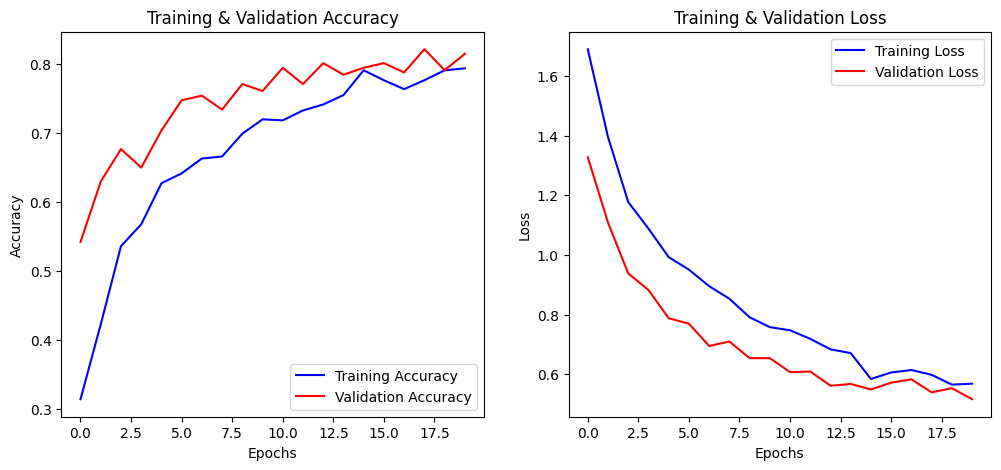

In [50]:
# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 765ms/step


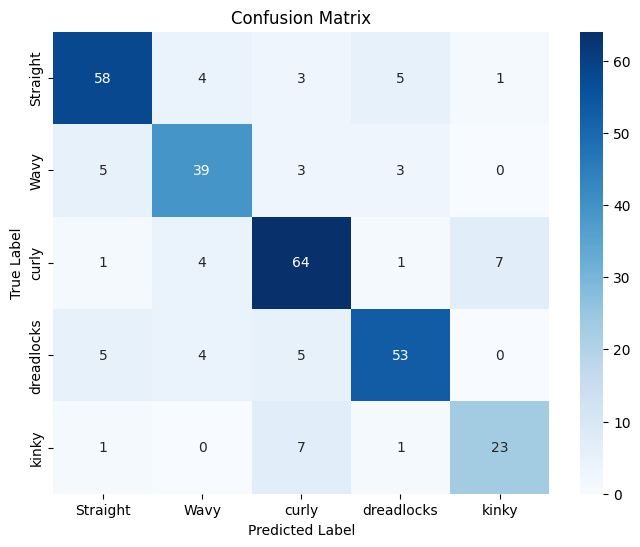

              precision    recall  f1-score   support

    Straight       0.83      0.82      0.82        71
        Wavy       0.76      0.78      0.77        50
       curly       0.78      0.83      0.81        77
  dreadlocks       0.84      0.79      0.82        67
       kinky       0.74      0.72      0.73        32

    accuracy                           0.80       297
   macro avg       0.79      0.79      0.79       297
weighted avg       0.80      0.80      0.80       297



In [51]:
# Predict on test set
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# **Experiment 2**

In [52]:
# Data Splitting
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Class"], random_state=42)

**Display Class Shapes After Splitting**

Number of Samples per Class After Splitting:
            Training  Test  Total
Class                            
Straight         389    98    487
Wavy             264    66    330
curly            411   103    514
dreadlocks       354    89    443
kinky            174    43    217


<Figure size 1000x600 with 0 Axes>

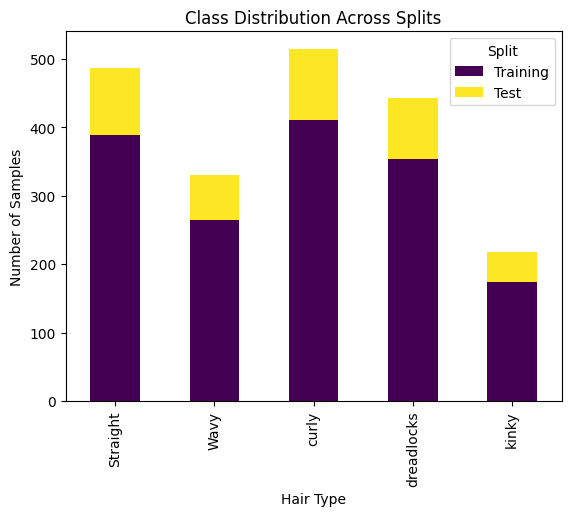

In [53]:
# Count samples per class in each split
train_counts = train_df['Class'].value_counts().sort_index()
test_counts = test_df['Class'].value_counts().sort_index()

# Combine counts into a single DataFrame for display
split_counts = pd.DataFrame({
    'Training': train_counts,
    'Test': test_counts
}).fillna(0).astype(int)  # Fill NaN with 0 and convert to int

# Add total counts for reference
split_counts['Total'] = split_counts['Training'] + split_counts['Test']

# Display the table
print("Number of Samples per Class After Splitting:")
print(split_counts)

# Optional: Visualize the split distribution
plt.figure(figsize=(10, 6))
split_counts[['Training','Test']].plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Class Distribution Across Splits")
plt.xlabel("Hair Type")
plt.ylabel("Number of Samples")
plt.legend(title="Split")
plt.show()

**Define Data Generators**

In [54]:
if class_name in ["Kinky", "Wavy"]:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True
    )
test_datagen = ImageDataGenerator(rescale=1./255)

**Setup Data Generators**

In [55]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=dataset_path,
    x_col="filename",
    y_col="Class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=dataset_path,
    x_col="filename",
    y_col="Class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

Found 1589 validated image filenames belonging to 5 classes.
Found 397 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [56]:
from sklearn.utils.class_weight import compute_class_weight
# Extract class labels
y_train = train_generator.classes  # Get labels for training set
class_labels = list(train_generator.class_indices.keys())

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print("Class Indices:", train_generator.class_indices)
print("Class Weights:", class_weight_dict)

Class Indices: {'Straight': 0, 'Wavy': 1, 'curly': 2, 'dreadlocks': 3, 'kinky': 4}
Class Weights: {0: 0.8190721649484536, 1: 1.2083650190114068, 2: 0.7751219512195122, 3: 0.8977401129943503, 4: 1.8264367816091953}


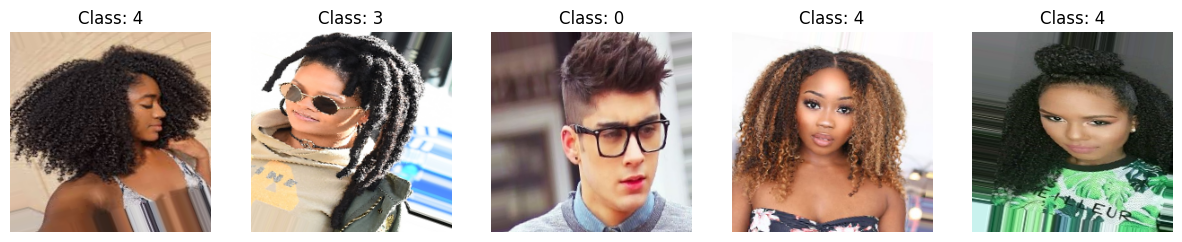

In [57]:
# Get a batch of images and labels
sample_batch, sample_labels = next(train_generator)

# Display some augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(sample_batch[i])
    axes[i].axis("off")
    axes[i].set_title(f"Class: {int(sample_labels[i])}")

plt.show()

In [58]:
# Clone the existing model for Experiment 2
model_exp2 = tf.keras.models.clone_model(model)
model_exp2.set_weights(model.get_weights())  # Copy weights from the previous model

# Compile the new model for Experiment 2
model_exp2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [59]:
import math

steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)

history_exp2 = model_exp2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
                ReduceLROnPlateau(monitor="loss", factor=0.2, patience=3, min_lr=1e-6)]

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7737 - loss: 0.6169 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7806 - loss: 0.5970 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7744 - loss: 0.5763 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7858 - loss: 0.5715 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7872 - loss: 0.5669 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8370 - loss: 0.4892 - learning_rate: 1.0000e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8044 - loss: 0.4834 - learning_rate: 1.0000e-04
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8172 - loss: 0.4711 - learning_rate: 1.0000e-04
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8106 - loss: 0.5084 - learning_rate: 1.0

In [60]:
test_loss, test_accuracy = model_exp2.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 564ms/step - accuracy: 0.8516 - loss: 0.5007
Test Accuracy: 0.8388, Test Loss: 0.5097


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 582ms/step


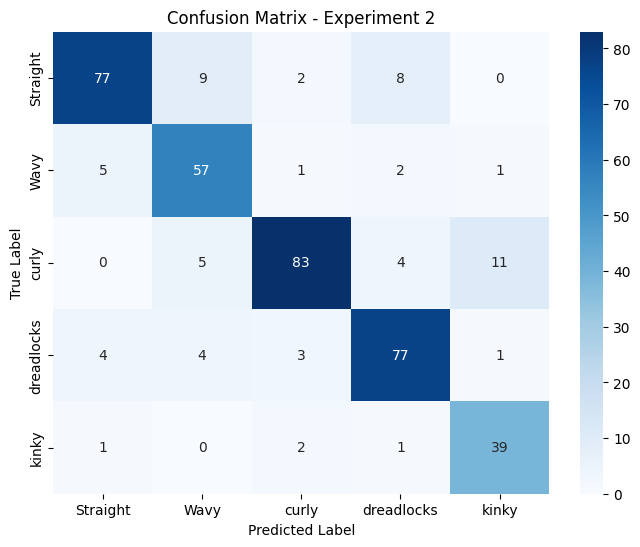

              precision    recall  f1-score   support

    Straight       0.89      0.80      0.84        96
        Wavy       0.76      0.86      0.81        66
       curly       0.91      0.81      0.86       103
  dreadlocks       0.84      0.87      0.85        89
       kinky       0.75      0.91      0.82        43

    accuracy                           0.84       397
   macro avg       0.83      0.85      0.84       397
weighted avg       0.85      0.84      0.84       397



In [61]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test set for Experiment 2
y_true_exp2 = test_generator.classes
predictions_exp2 = model_exp2.predict(test_generator)
y_pred_exp2 = np.argmax(predictions_exp2, axis=1)

# Compute confusion matrix
cm_exp2 = confusion_matrix(y_true_exp2, y_pred_exp2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_exp2, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Experiment 2")
plt.show()

# Classification report
print(classification_report(y_true_exp2, y_pred_exp2, target_names=test_generator.class_indices.keys()))

In [62]:
# model_exp2.save("model_exp2.h5")

# **Experiment 3**

In [63]:
# Clone model from Experiment 3 to continue training
model_exp3 = tf.keras.models.clone_model(model_exp2)
model_exp3.set_weights(model_exp2.get_weights())  # Copy the last weights from Experiment 3

# Unfreeze last 15 layers for fine-tuning
for layer in model_exp3.layers[-15:]:
    layer.trainable = True

# Compile the model with updated Learning Rate directly
model_exp3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),  # Lower LR for fine-tuning
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])
# Print model summary to check trainable layers
model_exp3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_145 (InputLayer)        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,692,869 (105.64 MB)

 Trainable params: 25,957,381 (99.02 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [64]:
# Continue training with Fine-Tuning
history_exp3 = model_exp3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
                ReduceLROnPlateau(monitor="loss", factor=0.2, patience=3, min_lr=1e-6)]

)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8728 - loss: 0.3430 - learning_rate: 3.0000e-06
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8938 - loss: 0.3025 - learning_rate: 3.0000e-06
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8936 - loss: 0.3040 - learning_rate: 3.0000e-06
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8908 - loss: 0.3051 - learning_rate: 3.0000e-06
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8851 - loss: 0.2760 - learning_rate: 3.0000e-06
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9038 - loss: 0.2762 - learning_rate: 3.0000e-06
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9135 - loss: 0.2354 - learning_rate: 3.0000e-06
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8897 - loss: 0.2902 - learning_rate: 3.0000e-06
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9173 - loss: 0.2356 - learning_rate: 3.0

In [65]:
test_loss, test_accuracy = model_exp3.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step - accuracy: 0.8503 - loss: 0.4899
Test Accuracy: 0.8514, Test Loss: 0.4940


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 727ms/step


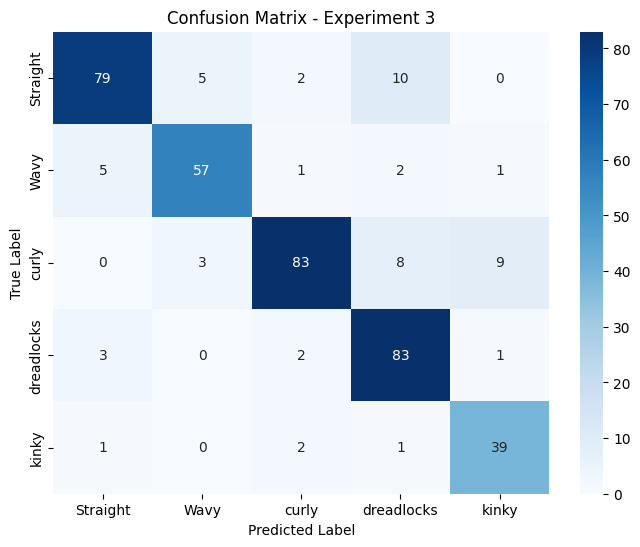

              precision    recall  f1-score   support

    Straight       0.90      0.82      0.86        96
        Wavy       0.88      0.86      0.87        66
       curly       0.92      0.81      0.86       103
  dreadlocks       0.80      0.93      0.86        89
       kinky       0.78      0.91      0.84        43

    accuracy                           0.86       397
   macro avg       0.85      0.87      0.86       397
weighted avg       0.87      0.86      0.86       397



In [66]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test set for Experiment 3
y_true_exp3 = test_generator.classes
predictions_exp3 = model_exp3.predict(test_generator)
y_pred_exp3 = np.argmax(predictions_exp3, axis=1)

# Compute confusion matrix
cm_exp3 = confusion_matrix(y_true_exp3, y_pred_exp3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_exp3, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Experiment 3")
plt.show()

# Classification report
print(classification_report(y_true_exp3, y_pred_exp3, target_names=test_generator.class_indices.keys()))

In [67]:
# model_exp3.save("VGG_model.h5")